In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os

In [2]:
################################'Generate regressor X from an AR(1)'##############################
################################ Xt = α + βXt-1 + εt

T=100;  # sample size
df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y' ])
alpha = 1;    # intercept parameter
beta = 0.9;   # autoregressive parameter
sigma = 0.1;  # standard error of innovations
x1 = alpha/(1-beta) # define initial value for time series x

epsilon = sigma*np.random.randn(T); # generate a vector of T random normal
df.iloc[0,:] = [x1] # initialize x

for i in range(0, T-1):
    df.iloc[i+1,0] = alpha + beta * df.iloc[i,0] + epsilon[i+1] # generate X(t) recursively
    # Xt = α + βXt-1 + εt


In [3]:
################################ Generate Y ##############################
################################ # Yt = α + βYt-1 + γXt + εt + θεt-1

T_2=100 
alpha_y = 1
beta_y = 0.9
gamma = 0.9
theta = 0.5
sigma = 0.1
epsilon_y = sigma*np.random.randn(T_2,1)
df['epsilon_y'] = epsilon_y
y1 = 0
df['y'] = 0

for j in range(0, T-1):
    df.iloc[j+1,1] = alpha_y + beta_y * df.iloc[j,1] + gamma * df.iloc[j+1,0] + epsilon_y[j] + theta * epsilon_y[j-1]
    # Yt = α + βYt-1 + γXt + εt + θεt-1

print(df)


            x          y  epsilon_y
0        10.0   0.000000  -0.020730
1   10.158459  10.139721  -0.110601
2   10.146056  19.136233  -0.032708
3   10.028174  27.159958   0.063870
4   10.172097  34.646365  -0.048162
..        ...        ...        ...
95   9.644024  98.581195  -0.113247
96   9.773247  98.388638   0.040575
97   9.900607  98.444272  -0.045334
98   9.946267  98.526439   0.012159
99  10.041231  98.700395   0.035678

[100 rows x 3 columns]


In [4]:
import statsmodels.formula.api as smf

# Fit quantile regression at the 0.5 quantile
y = df['y'].values.astype(float)
x = df['x'].values.astype(float)
epsilon_y = df['epsilon_y'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon_y, 1)
epsilon_lag[0] = 0

quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.1)
quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.5)
quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.9)

#quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x + epsilon_y + theta * epsilon_lag).fit(q=0.1)
#quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x + epsilon_y + theta * epsilon_lag).fit(q=0.5)
#quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x + epsilon_y + theta * epsilon_lag).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary())


                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.9804
Model:                       QuantReg   Bandwidth:                      0.1211
Method:                 Least Squares   Sparsity:                       0.4643
Date:                Sun, 05 Mar 2023   No. Observations:                  100
Time:                        10:52:44   Df Residuals:                       99
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9988      0.000   6786.687      0.000       0.998       0.999
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.9813
Model:                       QuantReg   Bandwidth:  

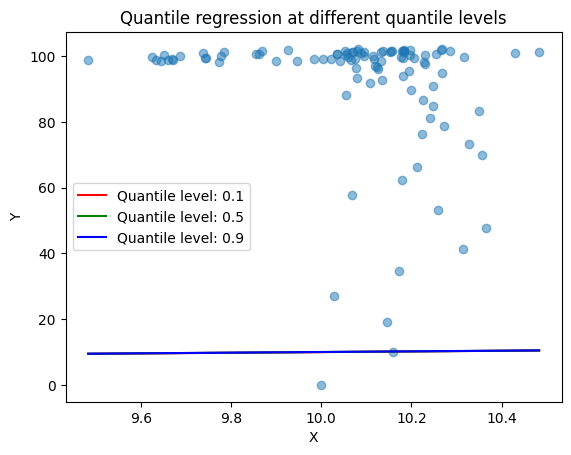

In [5]:
################################ Quantile regression plot ##############################
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
# Create a scatter plot of the data
plt.scatter(x, y, alpha=0.5)

# Plot the quantile regression lines at different quantile levels
x_sort = np.sort(x)
y_pred_1 = quant_reg_1.predict(x_sort)
y_pred_5 = quant_reg_5.predict(x_sort)
y_pred_9 = quant_reg_9.predict(x_sort)

plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

# Add a legend and labels to the plot
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quantile regression at different quantile levels')
plt.show()



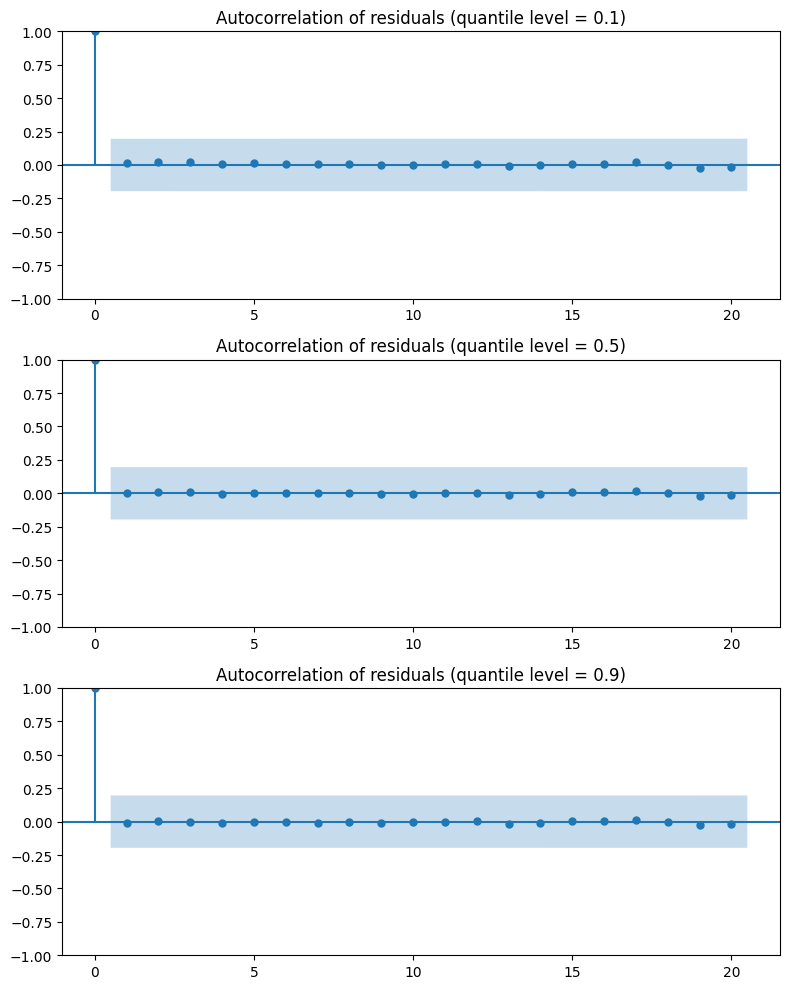

In [6]:
################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

#Autocorrelation fades away as the lags increase



In [7]:
################################ OLS estimation of the parameters ##############################
# Add lagged values of Y and epsilon
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon_y, 1)
epsilon_lag[0] = 0

# Construct the design matrix
X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))

#This line creates a new numpy array called X that is the design matrix for regression. 
# It is created by stacking columns of np.ones_like(x) (a vector of ones with the same shape as x), 
# y_lag, x, and epsilon_lag horizontally using np.column_stack(). 
# The first column of X is a vector of ones to represent the intercept term.

# Estimate the parameters
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Print the parameter estimates
print("alpha_hat = {:.4f}".format(beta_hat[0]))
print("beta_hat = {:.4f}".format(beta_hat[1]))
print("gamma_hat = {:.4f}".format(beta_hat[2]))
print("theta_hat = {:.4f}".format(beta_hat[3]))

alpha_hat = -7.2099
beta_hat = 0.9191
gamma_hat = 1.5348
theta_hat = 0.8468


In [9]:
################################ GLS estimation of the parameters ##############################
resid = y - X @ beta_hat# Compute the residuals

acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05) # Compute the ACF of the residuals

# Estimate the covariance parameters
sigma2 = np.var(resid) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)

# Compute the GLS estimator of the coefficients
beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y

# Print the parameter estimates
print("alpha_hat = {:.4f}".format(beta_gls[0]))
print("beta_hat = {:.4f}".format(beta_gls[1]))
print("gamma_hat = {:.4f}".format(beta_gls[2]))
print("theta_hat = {:.4f}".format(beta_gls[3]))

alpha_hat = -7.0789
beta_hat = 0.9189
gamma_hat = 1.5239
theta_hat = 0.8515


In [ ]:
################################ Laplace normal ##############################

In [ ]:
################################ Laplace with diagonal ##############################